# Regression with Gaussian Processes

I had heard of Gaussian processes a while ago but admittedly failed to understand them and their usefulness. However, in my MSc we had a great ML course which focused on bayesian inference. The professor and the assignments were great and I was able to understand for the first time what bayesian inference is about. Also, I started reading about MCMC algorithms and their ability to solve intractable problems. Armed with all this knowledge I felt more comfortable than ever on giving a second chance at Gaussian processes.

"Hey, the code below looks familiar", then you probably watched [this PyData talk](https://www.youtube.com/watch?v=j7Ruu3Yu-70&ab_channel=PyData) from Crhis Fonnesbeck. He is a pymc developper and has given really nice talks that focus on how to interpret abstract statistical problems to code.

**The dataset**  
Have you ever played DnD? If not, it is a fantasy role-playing game that I greatly suggest to look into. If yes, then you probably have heard of Hit Points (HP) and Challenge Rating (CR). HP measures how much you must hit something in order to defeat it, while CR measures how difficult it would be to defeat it. You might think that these two values are completely correlated. But, if a player attempts to destroy a wall, the wall will have many hit points but a small challenge rating, since the chances of anyone losing from a wall are slim.
I got the HP and CR of all the monsters by scraping [aidedd](https://www.aidedd.org/dnd-filters/monsters.php).

**An outline**  
In our use case, we want to predict the challenge rating of a monster given its hitpoints. We will start with simple linear regression, but instead of the analytical least squares solution, we will sample the parameters from a distribution using MCMC. Then, we will use a gaussian process with a squared exponential kernel and compare these two approaches. 

In [ ]:
import pymc3 as pm
from pymc3.gp.util import plot_gp_dist

import pickle
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import warnings
import random
warnings.filterwarnings('ignore')

## Reading the data

The dataset is stored into a pickle file which has stored a dictionary in the structure of:
```
{
    Monster_Name1 (str): (HP (int), CR (int)),
    Monster_Name2 (str): (HP (int), CR (int)),
    ...
}
```
We read the file and remove duplicate HPs mainly for visualization reasons to be able to see all the datapoints distinctly.

In [2]:
with open('datasets/monster_hp_cr.pickle', 'rb') as handle:
    monster_hp_cr = pickle.load(handle)

In [3]:
sorted_hp_cr_dup = sorted(monster_hp_cr.values(), key=lambda x : x[0])

# We remove duplicate HPs to simplify the following visualizations
seen_hp = set()
sorted_hp_cr = []
for hp_cr in sorted_hp_cr_dup:
    if hp_cr[0] not in seen_hp:
        sorted_hp_cr.append(hp_cr)
        seen_hp.add(hp_cr[0])

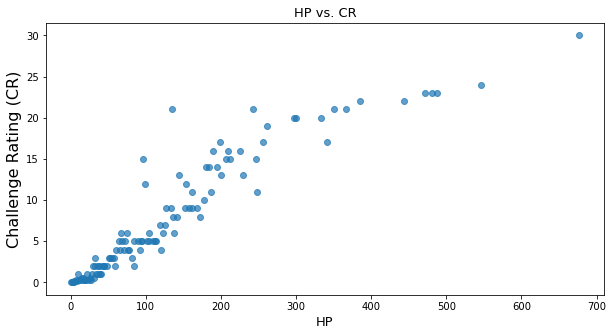

In [131]:
# A numpy array in which have one row per monster and two columns, health points and challenge rating
sorted_hp_cr = np.array(sorted_hp_cr)

fig = plt.figure(figsize=(10, 5))
plt.scatter(sorted_hp_cr[:, 0], sorted_hp_cr[:, 1], alpha=0.7)
plt.xlabel("HP", fontsize=13)
plt.ylabel("Challenge Rating (CR)", fontsize=16)
plt.title("HP vs. CR", fontsize=13)
plt.show()

We can imagine that while the regession line should be linear at the start, after 200 HP it has a more logarithmic shape.

## Linear Regression

We want to fit a simple linear regression model of 1st degree polynomial. The line would be given by $y = b_0 + b_1x$. Now we must estimate the two paramters $b_0, b_1$. We probably have heard of an analytical solution to this problem called Least Squares in which we minimize the square error (distance) of the points from the line we fitted. However, while this technique is fast it is not able to provide us info about the certainty of the correctness of the parameters. Instead, we sample both the parameters from normal distributions. Also, we can model the noise and get an estimation of the noise distribution too.

In [132]:
random_monsters = random.sample(range(len(sorted_hp_cr)), 100)

x = sorted_hp_cr[[random_monsters], 0].T  # Our known feature (hp)
y = sorted_hp_cr[[random_monsters], 1].T  # The challenge rating we to regress
x_test = np.delete(sorted_hp_cr, random_monsters, axis=0)[:, 0].T
y_test = np.delete(sorted_hp_cr, random_monsters, axis=0)[:, 1].T

with pm.Model() as linear_model:
    
    beta = pm.Normal('beta', mu=0, sigma=50, shape=2)  # Coefficients
    sigma = pm.HalfNormal('sigma', sigma=50)  # Noise
    
    mu = beta[0] + beta[1] * x
    
    cr = pm.Normal('cr', mu=mu, sigma=sigma, observed=y)
    
    linear_trace = pm.sample(1000, tune=2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:06<00:00, 979.13draws/s] 


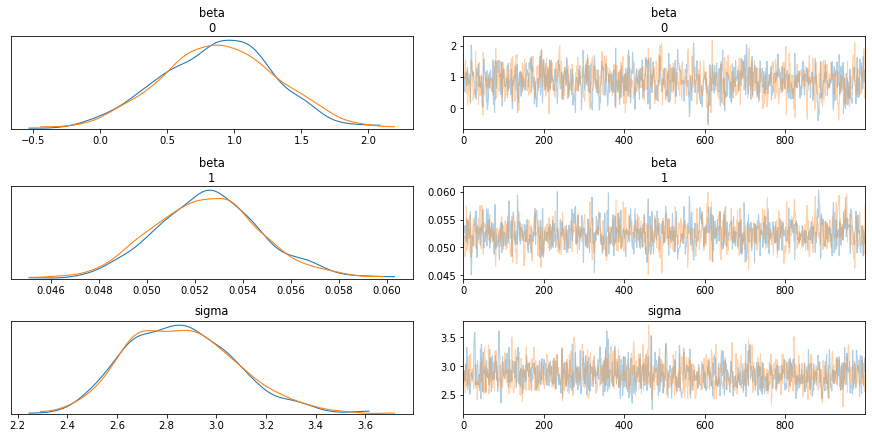

In [133]:
with linear_model:
    k = az.plot_trace(linear_trace)

The above plot showcases the advantage of the MCMC approach. The result parameters **are not specific scalar values but distributions** from which we can sample. This means that we can are able to quantify the goodness of our fit. If the result distributions have a high variance then our model was not able to capture the shape of our data and vice versa. Feel free to change the number of mosnters used as a train set and observe how the result distributions change shape.

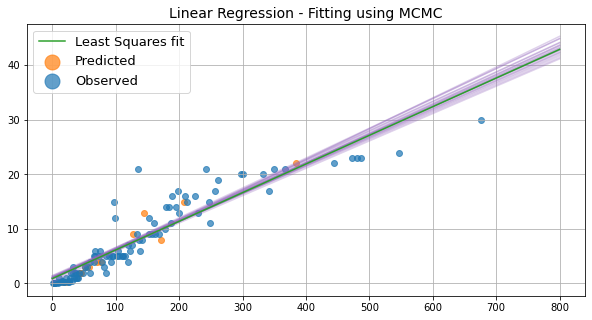

In [134]:
# Perform a least squares analytical fit (1st degree)
X_least = np.array([np.ones(len(x)), x[:, 0]]).T
thetas = np.linalg.inv(X_least.T @ X_least) @ X_least.T @ y

fig = plt.figure(figsize=(10, 5))

X_pred = np.linspace(0, 800, 100)
plt.scatter(x_test, y_test, label="Predicted", color="tab:orange", alpha=0.7)
plt.scatter(x, y, label="Observed", color="tab:blue", alpha=0.7)
for b0,b1 in linear_trace['beta'][:20]:
    plt.plot(X_pred, b0 + b1*X_pred, alpha=0.3, color='tab:purple')
plt.plot(X_pred, thetas[0] + thetas[1]*X_pred, label="Least Squares fit", color="tab:green")
plt.legend(prop={'size': 13}, markerscale=2.5)
plt.grid()
plt.title("Linear Regression - Fitting using MCMC", fontsize=14)
plt.show()

### Selecting a bad prior

On the above experiment we had as a prior of the parameters a normal distribution of mean 0 and sigma 50. This is a shallow distribution that avoid making hard prior decisions. Now we examine that the choice of prior can have major impact on the result model. Below, we define as the prior distribution of thetas a uniform distribution in the range of [-1, 0]. This is like saying "I am certain that my parameters are between [-1, 0] and nowhere else. Of course, we expect a really bad fit since our dataset is positive correlated.

In [135]:
with pm.Model() as linear_model_bad_prior:
    
    beta = pm.Uniform('beta', lower=-1, upper=0, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=50)
    
    mu = beta[0] + beta[1] * x
    
    cr = pm.Normal('cr', mu=mu, sigma=sigma, observed=y)
    
    linear_trace = pm.sample(1000, tune=2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:04<00:00, 1308.08draws/s]


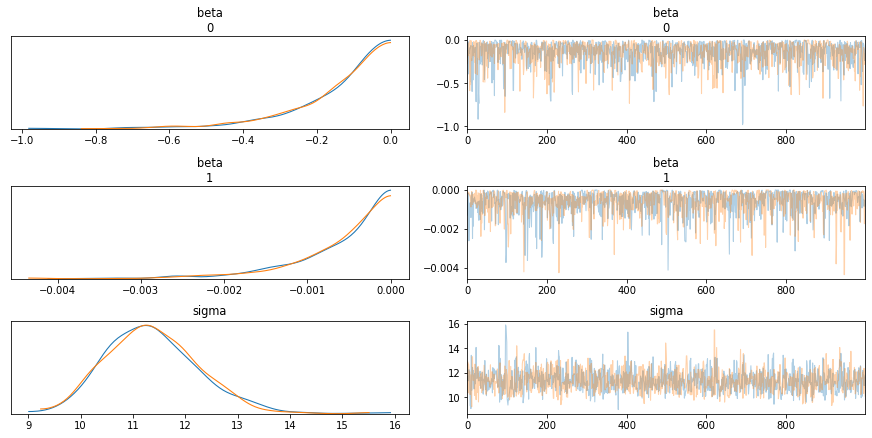

In [136]:
with linear_model_bad_prior:
    k = az.plot_trace(linear_trace)

The plot above shows that we must always diagnose our MCMC results. We can clearly see both parameters trying to go above 0 which of course cannot do since we have constrained them with our prior. Diagnosing these results most of the times is not that easy, but oymc offers a set of techniques that can help you.

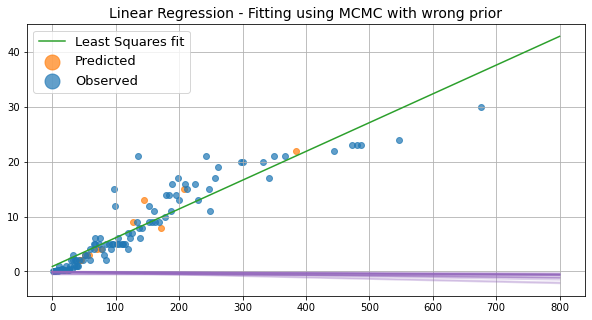

In [138]:
# Perform a least squares analytical fit (1st degree)
X_least = np.array([np.ones(len(x)), x[:, 0]]).T
thetas = np.linalg.inv(X_least.T @ X_least) @ X_least.T @ y

fig = plt.figure(figsize=(10, 5))

X_pred = np.linspace(0, 800, 100)
plt.scatter(x_test, y_test, label="Predicted", color="tab:orange", alpha=0.7)
plt.scatter(x, y, label="Observed", color="tab:blue", alpha=0.7)
for b0,b1 in linear_trace['beta'][:20]:
    plt.plot(X_pred, b0 + b1*X_pred, alpha=0.3, color='tab:purple')
plt.plot(X_pred, thetas[0] + thetas[1]*X_pred, label="Least Squares fit", color="tab:green")
plt.legend(prop={'size': 13}, markerscale=2.5)
plt.grid()
plt.title("Linear Regression - Fitting using MCMC with wrong prior", fontsize=14)
plt.show()

As expected the purple lines we create by sampling the result distributions cannot fit our data since they were doomed from our prior selection.

## Gaussian Process

I believe that we now have a small grasp of what pymc is doing and the power of MCMC algorithms. We will now perform the above regression task using a Gausian process. Gaussian processes came from the observation that two things that have similar values on variable x, then they have similar values on variable y with high probability. In other words, it expects that our data is smooth. This model describes many phenomena, for example, the temperature gradually increases from morning to noon.

But how do we model this similarity? Through the covariance matrix (also called kernel). In our case, we use the squared exponential kernel:
$$
k(x, x') = σ^2 exp \left(-\dfrac{(x-x')^2}{2l^2}\right)
$$

We can easily see that when x and x' are similar k(x, x') gets bigger and vice versa. The l parameter (in the code below it is named ro) controls how important it is for the x, x' to be similar.

In [120]:
random_monsters = random.sample(range(len(sorted_hp_cr)), len(sorted_hp_cr))

x = sorted_hp_cr[[random_monsters], 0].T  # Our known feature (hp)
y = sorted_hp_cr[[random_monsters], 1].T  # THe challenge rating we to regress
x_test = np.delete(sorted_hp_cr, random_monsters, axis=0)[:, 0].T
y_test = np.delete(sorted_hp_cr, random_monsters, axis=0)[:, 1].T

with pm.Model() as gp_model:
    # We sample both the length (ro) and the variance (eta)
    ro = pm.HalfCauchy('ro', 5)
#     ro = 10
    eta = pm.HalfCauchy('eta', 5)
    
    
    M = pm.gp.mean.Linear(coeffs=(y/x).mean())
    K = (eta**2) * pm.gp.cov.ExpQuad(1, ro) 
    
    sigma = pm.HalfNormal('sigma', 50)
    
    cr_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    cr_gp.marginal_likelihood('CR', X=x, y=y[:, 0], noise=sigma)

    gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=421)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, eta, ro]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:46<00:00, 129.23draws/s]


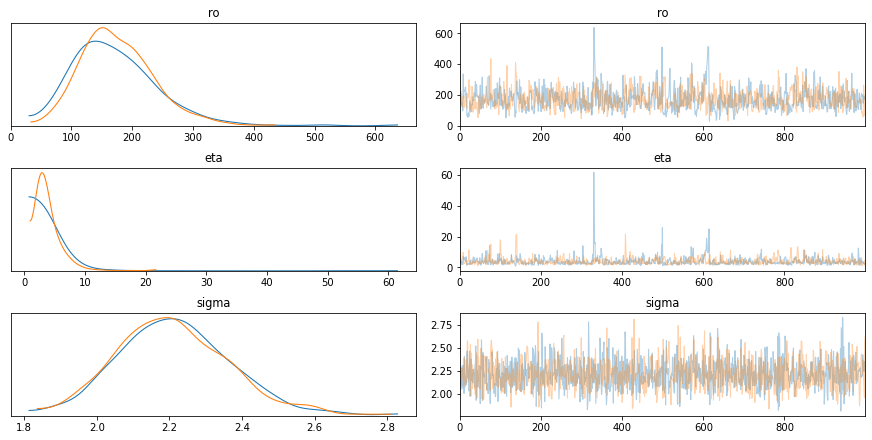

In [101]:
with gp_model:
    az.plot_trace(gp_trace, var_names=['ro', 'eta', 'sigma']);

**Note**: In the above example you can see that our both our priors and likelihood follow normal distributions and as a result our posterior distribution is normal too. This allows us to be able to calculate the posterior in closed form calling `marginal_likelihood`. This would not be possible if for example we had a Poisson likelihood distribution. However, pymc offers us a solution using [latent variable](https://docs.pymc.io/notebooks/GP-Latent.html). 

100%|██████████| 3/3 [00:00<00:00,  6.69it/s]


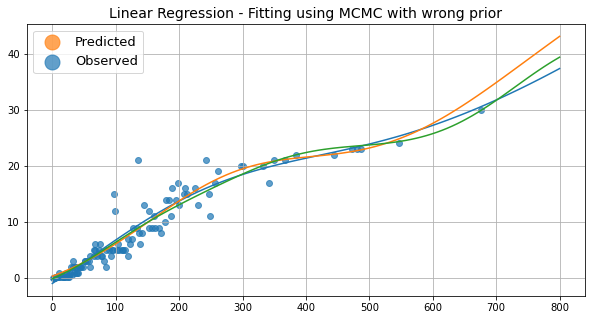

In [121]:
with gp_model:
    cr_pred = cr_gp.conditional("cr_pred", X_pred.reshape(-1, 1))
    gp_cr_samples = pm.sample_posterior_predictive(gp_trace, vars=[cr_pred], samples=3, random_seed=42)

fig = plt.figure(figsize=(10, 5))

X_pred = np.linspace(0, 800, 100)
plt.scatter(x_test, y_test, label="Predicted", color="tab:orange", alpha=0.7)
plt.scatter(x, y, label="Observed", color="tab:blue", alpha=0.7)
for x_samp in gp_cr_samples['cr_pred']:
    plt.plot(X_pred, x_samp);
# plt.plot(X_pred, thetas[0] + thetas[1]*X_pred, label="Least Squares fit", color="tab:green")
plt.legend(prop={'size': 13}, markerscale=2.5)
plt.grid()
plt.title("Linear Regression - Fitting using MCMC with wrong prior", fontsize=14)
plt.show()

We can see a really nice fit that does not need any huper-prameters like the polynomial degree taht we should have tuned in the least squares case. In the following plot we sample many Gaussian fits in order to get a feeling of where there are regions of high certainty or uncertainty.

100%|██████████| 100/100 [00:00<00:00, 116.65it/s]


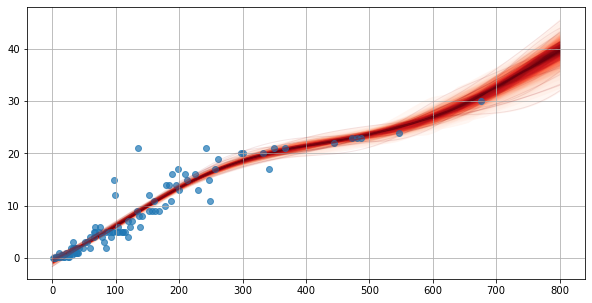

In [140]:
with gp_model:
    gp_samples = pm.sample_posterior_predictive(gp_trace, vars=[cr_pred], samples=100, random_seed=42)

fig, ax = plt.subplots(figsize=(10,5))
a = plot_gp_dist(ax, gp_samples['cr_pred'], X_pred)
plt.scatter(x, y, label="Observed", color="tab:blue", alpha=0.7)
plt.grid()
plt.show()

As expected, there is little variance at the start of the plot since we have many datapoints. However, this is not the case at the second half (x > 300). Since we have less data there is a lot of variance on our predictions. You can again tune the number of observed(training) points used and notice how the variance changes.

When I started reading into GPs I expected just a new tool or framework like SVM, neural networks, PCA etc. However, I found that a new way of thinking was required. I normally had data that I fed them into a model and then cross validated my results. Gaussian processes while they require some getting used to, offer great solutions and crucially new ways of validating these solutions like uncertainty measurements. I believe that if you like the bayesian way of solving problems, you will have a lot of fun with GPs.

In case you want to lear more about GPs, MCMC I suggest:
* Nando's de Freitas UCB graduate lectures: [GP1](https://www.youtube.com/watch?v=4vGiHC35j9s&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=8&ab_channel=NandodeFreitas), [GP2](https://www.youtube.com/watch?v=MfHKW5z-OOA&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=9&ab_channel=NandodeFreitas), [Bayesian Optimization](https://www.youtube.com/watch?v=vz3D36VXefI&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=10&t=1s&ab_channel=NandodeFreitas), [MCMC1](https://www.youtube.com/watch?v=TNZk8lo4e-Q&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=20&ab_channel=NandodeFreitas), [MCMC2](https://www.youtube.com/watch?v=sK3cg15g8FI&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=21&ab_channel=NandodeFreitas)
* [A visual exploration of GPs](https://distill.pub/2019/visual-exploration-gaussian-processes/)
* Chris' talks: [GPs](https://www.youtube.com/watch?v=j7Ruu3Yu-70&ab_channel=PyData), [MCMC](https://www.youtube.com/watch?v=SS_pqgFziAg&t=4713s&ab_channel=PyData)

$$
The \hspace{1mm} End!
$$